Cryptocurrency Correlation Analysis
Fetching top 20 cryptocurrencies by market cap and analyzing their price correlations using CCXT

In [1]:
!pip install ccxt pandas numpy matplotlib seaborn yfinance

In [2]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

from matplotlib.colors import LinearSegmentedColormap

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(14, 12))
fig.patch.set_facecolor('#1a1a1a')
ax.set_facecolor('#1a1a1a')

In [3]:
exchange = ccxt.binance()
markets = exchange.load_markets()
tickers = exchange.fetch_tickers()

In [4]:
ticker_data = []
for symbol, ticker in tickers.items():
    if '/USDT' in symbol and ticker['quoteVolume'] is not None:
        ticker_data.append({
            'symbol': symbol,
            'price': ticker['last'],
            'volume': ticker['quoteVolume'],
            'market_cap_proxy': ticker['last'] * ticker['baseVolume'] if ticker['baseVolume'] else 0
        })

df_tickers = pd.DataFrame(ticker_data)
df_tickers = df_tickers.sort_values('volume', ascending=False)
top_20_symbols = df_tickers.head(20)['symbol'].tolist()

print("Top 20 cryptocurrencies by trading volume:")
for i, symbol in enumerate(top_20_symbols, 1):
    print(f"{i}. {symbol}")

Top 20 cryptocurrencies by trading volume:
1. ETH/USDT
2. USDC/USDT
3. XRP/USDT
4. BTC/USDT
5. SOL/USDT
6. DOGE/USDT
7. FDUSD/USDT
8. ERA/USDT
9. PEPE/USDT
10. SUI/USDT
11. ADA/USDT
12. TRX/USDT
13. BNB/USDT
14. UNI/USDT
15. HBAR/USDT
16. BONK/USDT
17. XLM/USDT
18. PENGU/USDT
19. LINK/USDT
20. LTC/USDT


In [13]:
def fetch_ohlcv_data(exchange, symbol, timeframe='1d', limit=365):
    try:
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe, limit=limit)
        if not ohlcv or len(ohlcv) < 2:
            return None
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)
        return df['close']
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        return None

price_data = {}
failed_symbols = []

for symbol in top_20_symbols:
    print(f"Fetching data for {symbol}...")
    data = fetch_ohlcv_data(exchange, symbol, timeframe='1d', limit=365)
    if data is not None and len(data) >= 30:
        price_data[symbol.replace('/USDT', '')] = data
    else:
        failed_symbols.append(symbol)
    time.sleep(0.1)

print(f"\nSuccessfully fetched data for {len(price_data)} cryptocurrencies")
if failed_symbols:
    print(f"Failed to fetch sufficient data for: {failed_symbols}")

if price_data:
    sample_data = list(price_data.values())[0]
    print(f"Data points per symbol: {len(sample_data)}")
    print(f"Date range: {sample_data.index.min()} to {sample_data.index.max()}")

Fetching data for ETH/USDT...
Fetching data for USDC/USDT...
Fetching data for XRP/USDT...
Fetching data for BTC/USDT...
Fetching data for SOL/USDT...
Fetching data for DOGE/USDT...
Fetching data for FDUSD/USDT...
Fetching data for ERA/USDT...
Fetching data for PEPE/USDT...
Fetching data for SUI/USDT...
Fetching data for ADA/USDT...
Fetching data for TRX/USDT...
Fetching data for BNB/USDT...
Fetching data for UNI/USDT...
Fetching data for HBAR/USDT...
Fetching data for BONK/USDT...
Fetching data for XLM/USDT...
Fetching data for PENGU/USDT...
Fetching data for LINK/USDT...
Fetching data for LTC/USDT...

Successfully fetched data for 19 cryptocurrencies
Failed to fetch sufficient data for: ['ERA/USDT']
Data points per symbol: 365
Date range: 2024-07-19 00:00:00 to 2025-07-18 00:00:00


In [14]:
price_df = pd.DataFrame(price_data)
price_df = price_df.dropna()

returns_df = price_df.pct_change().dropna()

print("Price data shape:", price_df.shape)
print("Returns data shape:", returns_df.shape)
print("\nFirst few rows of price data:")
print(price_df.head())

Price data shape: (214, 19)
Returns data shape: (213, 19)

First few rows of price data:
                ETH    USDC     XRP        BTC     SOL     DOGE   FDUSD  \
timestamp                                                                 
2024-12-17  3893.01  0.9999  2.5673  106133.74  223.15  0.39415  0.9985   
2024-12-18  3626.80  1.0004  2.3103  100204.01  206.53  0.35824  0.9981   
2024-12-19  3417.01  1.0008  2.2390   97461.86  193.81  0.31431  0.9980   
2024-12-20  3472.21  1.0005  2.2793   97805.44  194.48  0.31793  0.9983   
2024-12-21  3338.92  1.0006  2.2380   97291.99  181.45  0.32042  0.9981   

                PEPE     SUI     ADA     TRX     BNB     UNI     HBAR  \
timestamp                                                               
2024-12-17  0.000022  4.6409  1.0522  0.2796  717.69  16.242  0.28468   
2024-12-18  0.000019  4.3361  0.9681  0.2581  686.38  14.807  0.27244   
2024-12-19  0.000017  4.0754  0.8806  0.2513  665.62  12.726  0.26766   
2024-12-20  0.000018

In [15]:
print("Data info:")
print(f"Returns DataFrame shape: {returns_df.shape}")
print(f"Non-null values per column:\n{returns_df.count()}")
print(f"Columns with all NaN: {returns_df.columns[returns_df.isna().all()].tolist()}")
print(f"Any infinite values: {np.isinf(returns_df).any().any()}")

print("\nFirst few rows of returns data:")
print(returns_df.head())

print("\nLast few rows of returns data:")
print(returns_df.tail())

print("\nISSUE IDENTIFIED:")
print(f"You only have {returns_df.shape[0]} row(s) of returns data.")
print("Correlation requires at least 2 observations per variable.")
print("You need more historical price data to calculate meaningful correlations.")

print("\nSuggested fixes:")
print("1. Increase the 'limit' parameter in fetch_ohlcv_data() from 60 to a larger number")
print("2. Check if your price data actually contains multiple time periods")
print("3. Verify that dropna() isn't removing too many rows")

if returns_df.shape[0] >= 2:
    correlation_matrix = returns_df.corr()
    print(f"\nCorrelation matrix shape: {correlation_matrix.shape}")
    print(f"NaN values in correlation matrix: {correlation_matrix.isna().sum().sum()}")
    print("\nCorrelation Matrix:")
    print(correlation_matrix.round(3))
else:
    print("\nCannot calculate correlation matrix with less than 2 observations.")

Data info:
Returns DataFrame shape: (213, 19)
Non-null values per column:
ETH      213
USDC     213
XRP      213
BTC      213
SOL      213
DOGE     213
FDUSD    213
PEPE     213
SUI      213
ADA      213
TRX      213
BNB      213
UNI      213
HBAR     213
BONK     213
XLM      213
PENGU    213
LINK     213
LTC      213
dtype: int64
Columns with all NaN: []
Any infinite values: False

First few rows of returns data:
                 ETH    USDC       XRP       BTC       SOL      DOGE  \
timestamp                                                              
2024-12-18 -0.068382  0.0005 -0.100105 -0.055870 -0.074479 -0.091107   
2024-12-19 -0.057844  0.0004 -0.030862 -0.027366 -0.061589 -0.122627   
2024-12-20  0.016154 -0.0003  0.017999  0.003525  0.003457  0.011517   
2024-12-21 -0.038388  0.0001 -0.018120 -0.005250 -0.066999  0.007832   
2024-12-22 -0.017098  0.0004 -0.015594 -0.021643 -0.005125 -0.024343   

               FDUSD      PEPE       SUI       ADA       TRX       BNB  \
ti

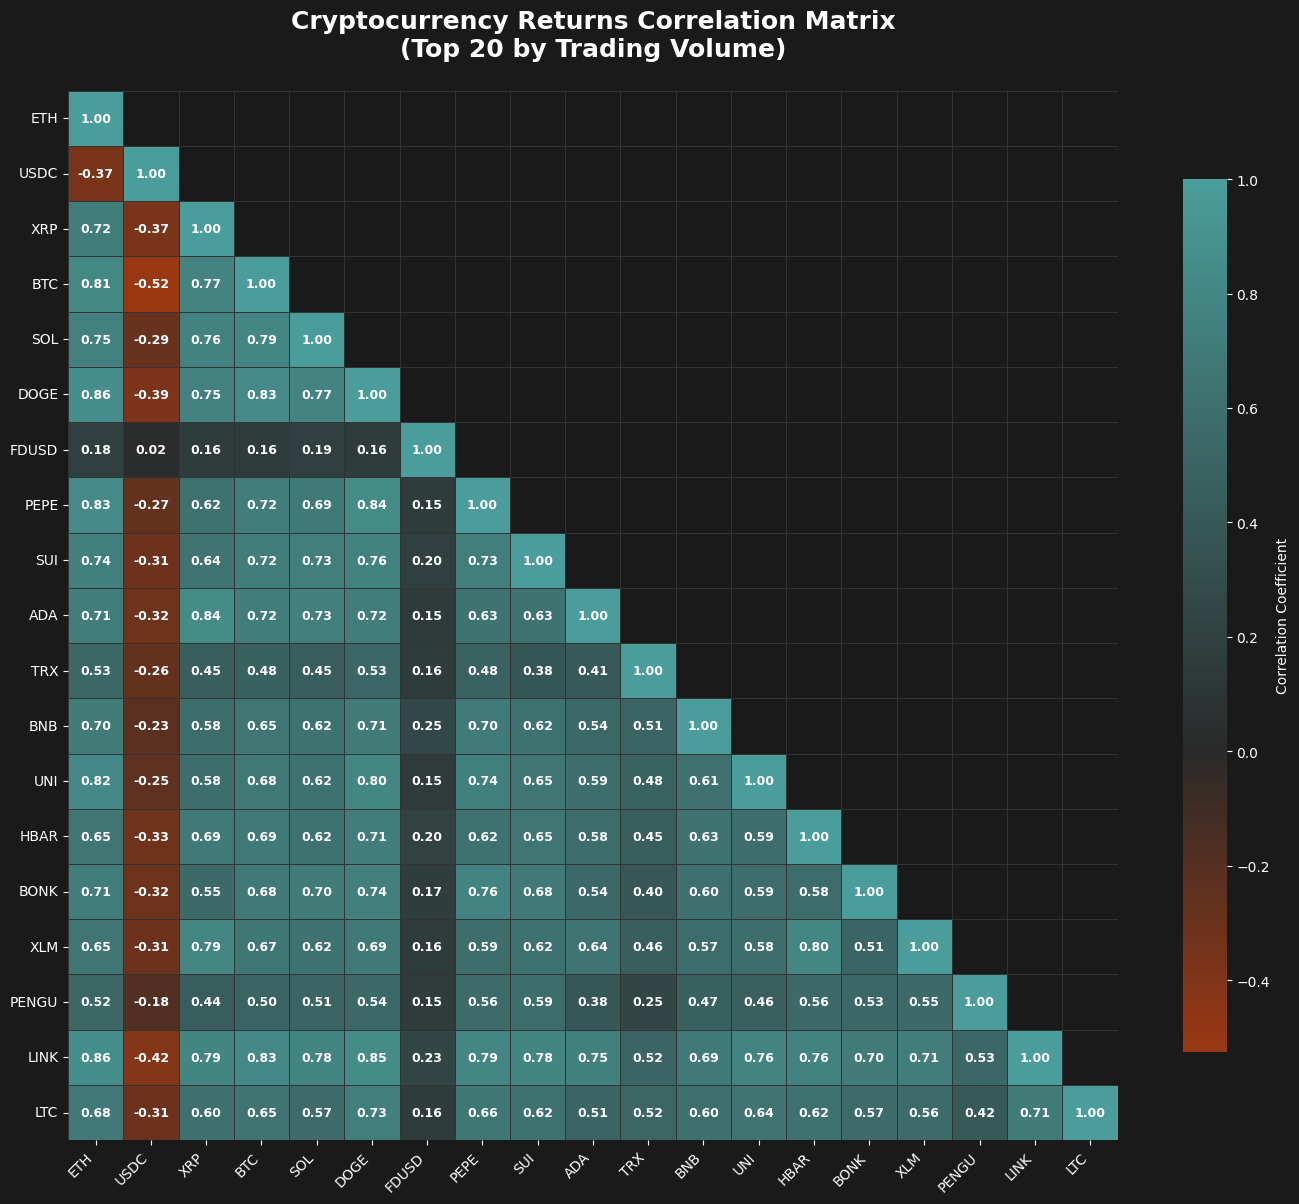

In [20]:



colors = ['#FF4500', '#2a2a2a', '#4A9D9A']
n_bins = 256
cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

sns.heatmap(correlation_matrix,
            mask=mask,
            annot=True,
            cmap=cmap,
            center=0,
            square=True,
            fmt='.2f',
            linewidths=0.5,
            linecolor='#333333',
            cbar_kws={'shrink': 0.8, 'label': 'Correlation Coefficient'},
            annot_kws={'size': 9, 'color': 'white', 'weight': 'bold'})

plt.title('Cryptocurrency Returns Correlation Matrix\n(Top 20 by Trading Volume)', 
          fontsize=18, fontweight='bold', pad=25, color='white')
plt.xticks(rotation=45, ha='right', color='white', fontsize=10)
plt.yticks(rotation=0, color='white', fontsize=10)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(colors='white')
cbar.ax.yaxis.label.set_color('white')

plt.tight_layout()
plt.show()